In [1]:
import re, sys, json
import numpy as np
import pandas as pd
from collections import Counter
from numpy.random import rand, randint
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns
from random import uniform
import time
from IPython.display import display, clear_output
from copy import deepcopy

sys.path.append('../lib')

from game import roll_dice, Horse, Stable, ReadySetBetGame, Bet, BettingBoard, get_finish_function, get_expected_payouts

In [2]:
basic_starting_stable = Stable({
    '2/3': Horse(numbers=[2,3], bonus=3, position=0),
    '4': Horse(numbers=[4], bonus=3, position=0),
    '5': Horse(numbers=[5], bonus=2, position=0),
    '6': Horse(numbers=[6], bonus=1, position=0),
    '7': Horse(numbers=[7], bonus=0, position=0),
    '8': Horse(numbers=[8], bonus=1, position=0),
    '9': Horse(numbers=[9], bonus=2, position=0),
    '10': Horse(numbers=[10], bonus=3, position=0),
    '11/12': Horse(numbers=[11,12], bonus=3, position=0),
})


horse_names = ['2/3', '4', '5', '6', '7', '8', '9', '10', '11/12']

In [10]:
#
# Run N simulations from the start -- get placement frequencies and avg horse speed
#



###########   ADJUST THESE PARAMETERS   ###########

N = 1000 # Number of simulations to do

VISUALIZE = False # Try setting to True if you want to see race happen

TIME_STEP = 0.3

###################################################


logs = []
for i in range(N):
    game = ReadySetBetGame(stable=deepcopy(basic_starting_stable))
    log = game.play_game(visualize=VISUALIZE, time_step=TIME_STEP)
    logs.append(log)

column_order = horse_names

# Store placement info in DataFrame
df_placement = pd.DataFrame([log['placement'] for log in logs])[column_order]

print('\nFinished running simulations.')


Finished running simulations.


In [11]:
# Get overall stats

overall_total_rolls = sum([log['total_rolls'] for log in logs])
average_rolls_per_game = overall_total_rolls / N
print(f'Average rolls per game {average_rolls_per_game:0.1f}')

overall_total_spaces_moved = {name:sum([log['positions'][name] for log in logs]) for name in horse_names}
average_spaces_moved_per_roll = {name: round(overall_total_spaces_moved[name] / overall_total_rolls, 3) for name in horse_names}
average_spaces_moved_per_game = {name: round(overall_total_spaces_moved[name] / N, 1) for name in horse_names}
expected_rolls_per_space_moved = {name:round(1/val,1) for name, val in average_spaces_moved_per_roll.items()}
normalized_speed = {name:round(100*val/average_spaces_moved_per_roll['7']) for name, val in average_spaces_moved_per_roll.items()} # Relative to the 7 horse
print('\nAverage spaces moved per roll:')
print(json.dumps(average_spaces_moved_per_roll, indent=4))

print('\nAverage spaces moved per game:')
print(json.dumps(average_spaces_moved_per_game, indent=4))

print('\nAverage Speed Normalized to Horse 7:')
print(json.dumps(normalized_speed, indent=4))

print('\nExpected rolls per space moved:')
print(json.dumps(expected_rolls_per_space_moved, indent=4))

Average rolls per game 64.4

Average spaces moved per roll:
{
    "2/3": 0.102,
    "4": 0.101,
    "5": 0.131,
    "6": 0.156,
    "7": 0.168,
    "8": 0.153,
    "9": 0.134,
    "10": 0.106,
    "11/12": 0.1
}

Average spaces moved per game:
{
    "2/3": 6.6,
    "4": 6.5,
    "5": 8.4,
    "6": 10.1,
    "7": 10.8,
    "8": 9.8,
    "9": 8.6,
    "10": 6.8,
    "11/12": 6.4
}

Average Speed Normalized to Horse 7:
{
    "2/3": 61,
    "4": 60,
    "5": 78,
    "6": 93,
    "7": 100,
    "8": 91,
    "9": 80,
    "10": 63,
    "11/12": 60
}

Expected rolls per space moved:
{
    "2/3": 9.8,
    "4": 9.9,
    "5": 7.6,
    "6": 6.4,
    "7": 6.0,
    "8": 6.5,
    "9": 7.5,
    "10": 9.4,
    "11/12": 10.0
}


Text(0.5, 1.0, 'Placement Outcomes')

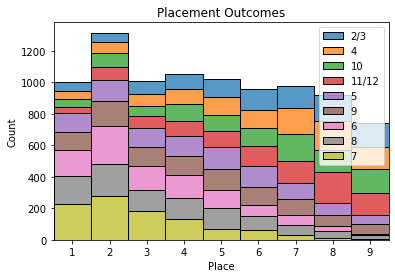

In [12]:
sns.histplot(data=df_placement[['2/3','4','10','11/12','5','9','6','8','7']], 
             multiple="stack", binwidth=1, binrange=[0.5, 10.5])
plt.xlabel('Place')
plt.xlim([0.5, 9.5])
plt.title('Placement Outcomes')


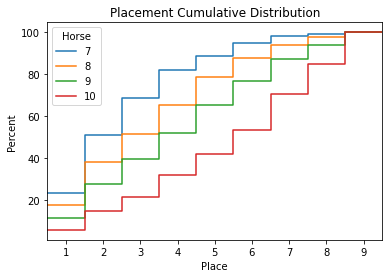

In [16]:

# sns.set(rc={'figure.figsize':(10,6)})
# sns.histplot(data=df_placement, cumulative=True, binwidth=1, binrange=[0.5, 10.5], 
#              stat='percent', element='step', fill=False)

# plt.xlabel('Place')
# plt.xlim([0.5, 9.5])
# plt.title('Cumulative')

horse_names_use = ['7', '8', '9', '10']

for i, name in enumerate(horse_names_use):
    if i==0:
        ax =sns.histplot(data=df_placement[name], binwidth=1, binrange=[.5, 9.5], 
                         element='step', fill=False, stat='percent', label=name, cumulative=True)
    else:
        sns.histplot(ax=ax, data=df_placement[name], binwidth=1, binrange=[.5, 9.5], 
                         element='step', fill=False, stat='percent', label=name, cumulative=True)
    plt.xlabel('Place')
    plt.xlim([.5, 9.5])
    plt.title(f"Placement Cumulative Distribution")
    plt.legend(title='Horse')

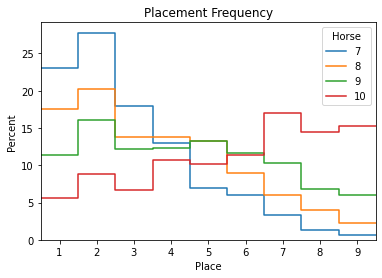

In [17]:
for i, name in enumerate(horse_names_use):
    if i==0:
        ax =sns.histplot(data=df_placement[name], binwidth=1, binrange=[.5, 9.5], 
                         element='step', fill=False, stat='percent', label=name)
    else:
        sns.histplot(ax=ax, data=df_placement[name], binwidth=1, binrange=[.5, 9.5], 
                         element='step', fill=False, stat='percent', label=name)
    plt.xlabel('Place')
    plt.xlim([.5, 9.5])
    plt.title(f"Placement Frequency")
    plt.legend(title='Horse')

In [18]:
#
# Calculate expected value for each bet
#

board = BettingBoard()

bet_amount = 3 # Standard chips are 2, 3, 3, 4, 5

expected_payouts = get_expected_payouts(bet_amount, board, logs)

# Display
print('\nBest bets by expected value:\n')
for item in sorted(list(expected_payouts.items()), key=lambda x: x[1], reverse=True):
    print(item)

Import standard bets
{'horse': '2/3', 'won': [[9, -3], [8, -2], [7, -2]], 'placed': [[5, -3], [5, -4]], 'showed': [[4, -3], [4, -4]]}
{'horse': '11/12', 'won': [[9, -3], [8, -2], [7, -2]], 'placed': [[5, -3], [5, -4]], 'showed': [[4, -3], [4, -4]]}
{'horse': '4', 'won': [[7, 0], [6, 0], [5, -1]], 'placed': [[4, 0], [4, -1]], 'showed': [[3, 0], [3, -1]]}
{'horse': '10', 'won': [[7, 0], [6, 0], [5, -1]], 'placed': [[4, 0], [4, -1]], 'showed': [[3, 0], [3, -1]]}
{'horse': '5', 'won': [[5, 0], [4, 0], [4, -2]], 'placed': [[3, -2], [2, -2]], 'showed': [[2, 0], [2, -3]]}
{'horse': '9', 'won': [[5, 0], [4, 0], [4, -2]], 'placed': [[3, -2], [2, -2]], 'showed': [[2, 0], [2, -3]]}
{'horse': '6', 'won': [[3, 0], [3, -1], [3, -2]], 'placed': [[2, -4], [2, -5]], 'showed': [[1, 0], [1, -2]]}
{'horse': '8', 'won': [[3, 0], [3, -1], [3, -2]], 'placed': [[2, -4], [2, -5]], 'showed': [[1, 0], [1, -2]]}
{'horse': '7', 'won': [[3, -2], [3, -3], [3, -4]], 'placed': [[2, -5], [2, -6]], 'showed': [[1, -1], [